<a href="https://colab.research.google.com/github/DiNOV-Tokyo/yolov5/blob/main/DL_torchvsion_DCGAN_Conditional_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 現場で使える！　PyTorchPyTorch開発入門


##翔泳社

## Conditonal GANに改良する。

https://github.com/pytorch/examples/blob/3b349ad2d189bb8afbfd38c8b496cd5b2e273412/dcgan/main.py

## 1.1 Google Drive をマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks
#%mkdir yolo_train
%cd yolo_train

/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/yolo_train


## 1.2 モジュール読み込み

In [ ]:
!pwd

/content


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import time

import numpy as np
from tqdm import tqdm
from PIL import Image
import os
import copy

#from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
from torchvision.utils import save_image

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

# GPU/CPUが使えるかどうか確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

PyTorch Version:  1.9.0+cu102
Torchvision Version:  0.10.0+cu102
Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


device(type='cuda', index=0)

##DCGANによる画像生成

Stanfrod Cars Dataset

http://ai.stanford.edu/~jkrause/cars/car_dataset.html

In [4]:
# http://ai.stanford.edu/~jkrause/cars/car_dataset.html
!wget http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
!tar xf cars_train.tgz
!mkdir stanford-car
!mkdir stanford-car/jpg
!mv cars_train/*.jpg stanford-car/jpg

--2021-09-20 05:19:21--  http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  10.3MB/s    in 75s     

2021-09-20 05:20:35 (12.5 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]



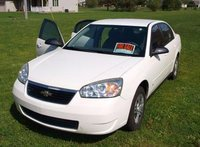

In [6]:
from IPython.display import Image,display_jpeg
#display_jpeg(Image('cars_train/080.jpg'))
display_jpeg(Image('./stanford-car/jpg/00018.jpg'))

In [40]:
path = "./stanford-car/jpg/"
files = os.listdir(path)
for f in files:
    if f=="06100.jpg":
      print("YES")
  

YES


In [34]:
!mkdir stanford-cars
!mkdir stanford-cars/jpg

In [35]:
!mv ./cars_train/*.jpg ./stanfod-cars/jpg/

mv: cannot stat './cars_train/*.jpg': No such file or directory


In [38]:
img_data = ImageFolder("./stanford-car/",
    transform=transforms.Compose([
        transforms.Resize(80),
        transforms.CenterCrop(64),
        transforms.ToTensor()
]))

batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size,
                        shuffle=True)

In [24]:
with open("stanford-car/train_perfect_preds.txt", "r", encoding="utf-8") as f:
    list = f.readlines()

len(list)
min(list)
ld = sorted(list, reverse=False)
list.count("196\n")
# 出現するclassは、1-196　

40

In [27]:
# one-hotのラベル生成
import numpy 

def to_onehot(label, class_num):
    return numpy.eye(class_num)[label]

to_onehot(5,10)

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

画像生成モデル

In [ ]:
nz = 100
ngf = 32

class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2, ngf,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf, 3,
                               4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.main(x)
        return out

識別モデル

In [ ]:
ndf = 32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

訓練関数の作成

In [ ]:
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

# Adamのパラメータは元論文の提案値
opt_d = optim.Adam(d.parameters(),
    lr=0.0002, betas=(0.5, 0.999))
opt_g = optim.Adam(g.parameters(),
    lr=0.0002, betas=(0.5, 0.999))

# クロスエントロピーを計算するための補助変数など
ones = torch.ones(batch_size).to("cuda:0")
zeros = torch.zeros(batch_size).to("cuda:0")
loss_f = nn.BCEWithLogitsLoss()

# モニタリング用のz
fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda:0")

In [ ]:
from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader):
    # 生成モデル、識別モデルの目的関数の追跡用の配列
    log_loss_g = []
    log_loss_d = []
    for real_img, _ in tqdm(loader):
        batch_len = len(real_img)
        
         # 実際の画像をGPUにコピー
        real_img = real_img.to("cuda:0")
        
         # 偽画像を乱数と生成モデルから作る
        z = torch.randn(batch_len, nz, 1, 1).to("cuda:0")
        fake_img = g(z)
        
        # 後で使用するので偽画像の値のみ取り出しておく
        fake_img_tensor = fake_img.detach()
        
        # 偽画像に対する生成モデルの評価関数を計算する
        out = d(fake_img)
        loss_g = loss_f(out, ones[: batch_len])
        log_loss_g.append(loss_g.item())
        
        # 計算グラフが生成モデルと識別モデルの両方に
        # 依存しているので両者とも勾配をクリアしてから
        # 微分の計算とパラメータ更新を行う
        d.zero_grad(), g.zero_grad()
        loss_g.backward()
        opt_g.step()

        # 実際の画像に対する識別モデルの評価関数を計算
        real_out = d(real_img)
        loss_d_real = loss_f(real_out, ones[: batch_len])
        
        # PyTorchでは同じTensorを含んだ計算グラフに対して
        # 2回backwardを行うことができないので保存してあった
        # Tensorを使用して無駄な計算を省く
        fake_img = fake_img_tensor
        
        # 偽画像に対する識別モデルの評価関数の計算
        fake_out = d(fake_img_tensor)
        loss_d_fake = loss_f(fake_out, zeros[: batch_len])
        
        # 実偽の評価関数の合計値
        loss_d = loss_d_real + loss_d_fake
        log_loss_d.append(loss_d.item())
        
        # 識別モデルの微分計算とパラメータ更新
        d.zero_grad(), g.zero_grad()
        loss_d.backward()
        opt_d.step()
        
    return mean(log_loss_g), mean(log_loss_d)

訓練開始

In [ ]:

import datetime

for epoch in range(300):
    train_dcgan(g, d, opt_g, opt_d, img_loader)
    print("{} Epoch {}: ".format(datetime.datetime.now(), epoch))
    # 10回の繰り返しごとに学習結果を保存する
    if epoch % 10 == 0:
        # パラメータの保存
        torch.save(
            g.state_dict(),
            "cars_train/g_{:03d}.prm".format(epoch),
            pickle_protocol=4)
        torch.save(
            d.state_dict(),
            "cars_train/d_{:03d}.prm".format(epoch),
            pickle_protocol=4)
        # モニタリング用のzから生成した画像を保存
        generated_img = g(fixed_z)
        save_image(generated_img,
                   "cars_train/{:03d}.jpg".format(epoch))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:03<00:00,  2.01it/s]


2021-09-19 01:56:00.679521 Epoch 0: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:06<00:00,  1.92it/s]


2021-09-19 01:57:07.479657 Epoch 1: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 01:58:09.450302 Epoch 2: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 01:59:10.724618 Epoch 3: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.10it/s]


2021-09-19 02:00:11.657596 Epoch 4: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.11it/s]


2021-09-19 02:01:12.187765 Epoch 5: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.10it/s]


2021-09-19 02:02:13.223193 Epoch 6: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.10it/s]


2021-09-19 02:03:14.108658 Epoch 7: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.10it/s]


2021-09-19 02:04:14.958776 Epoch 8: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.10it/s]


2021-09-19 02:05:15.954021 Epoch 9: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:06:17.400869 Epoch 10: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.10it/s]


2021-09-19 02:07:18.514033 Epoch 11: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 02:08:19.736022 Epoch 12: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 02:09:20.952656 Epoch 13: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:10:22.384737 Epoch 14: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.10it/s]


2021-09-19 02:11:23.397680 Epoch 15: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.10it/s]


2021-09-19 02:12:24.429009 Epoch 16: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 02:13:25.656871 Epoch 17: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:14:27.146109 Epoch 18: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 02:15:28.247988 Epoch 19: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.10it/s]


2021-09-19 02:16:29.348390 Epoch 20: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:17:30.834711 Epoch 21: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:18:32.462670 Epoch 22: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 02:19:33.846135 Epoch 23: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:20:35.417337 Epoch 24: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:21:37.096742 Epoch 25: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 02:22:38.346168 Epoch 26: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 02:23:39.664699 Epoch 27: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:24:41.162507 Epoch 28: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 02:25:42.462750 Epoch 29: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 02:26:43.768054 Epoch 30: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:27:45.351235 Epoch 31: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 02:28:46.482310 Epoch 32: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:29:48.015818 Epoch 33: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:30:49.516608 Epoch 34: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 02:31:51.370639 Epoch 35: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:32:52.828393 Epoch 36: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:33:54.324855 Epoch 37: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:34:55.812840 Epoch 38: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 02:35:57.160322 Epoch 39: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 02:36:58.963268 Epoch 40: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:38:00.579577 Epoch 41: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:39:02.136502 Epoch 42: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 02:40:04.277515 Epoch 43: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:41:05.800539 Epoch 44: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 02:42:07.943072 Epoch 45: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:43:09.531030 Epoch 46: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 02:44:11.458321 Epoch 47: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:45:12.923670 Epoch 48: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 02:46:14.660177 Epoch 49: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 02:47:16.488865 Epoch 50: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 02:48:18.697966 Epoch 51: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 02:49:20.075374 Epoch 52: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 02:50:21.990289 Epoch 53: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:51:23.641132 Epoch 54: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 02:52:25.684959 Epoch 55: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 02:53:27.003429 Epoch 56: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 02:54:28.758992 Epoch 57: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:55:30.261358 Epoch 58: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 02:56:32.146070 Epoch 59: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:57:33.619057 Epoch 60: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 02:58:35.787980 Epoch 61: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 02:59:37.332839 Epoch 62: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 03:00:39.236296 Epoch 63: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 03:01:40.623093 Epoch 64: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:02:42.872544 Epoch 65: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 03:03:43.987099 Epoch 66: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 03:04:46.427320 Epoch 67: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 03:05:47.716019 Epoch 68: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 03:06:50.193625 Epoch 69: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 03:07:51.802444 Epoch 70: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:08:53.992412 Epoch 71: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 03:09:55.423368 Epoch 72: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:10:57.573780 Epoch 73: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 03:11:59.487047 Epoch 74: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 03:13:01.877199 Epoch 75: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.06it/s]


2021-09-19 03:14:03.876625 Epoch 76: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 03:15:06.320564 Epoch 77: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 03:16:08.181030 Epoch 78: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:17:10.327937 Epoch 79: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 03:18:12.161686 Epoch 80: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:19:14.305636 Epoch 81: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 03:20:15.720761 Epoch 82: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 03:21:18.108101 Epoch 83: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 03:22:19.837031 Epoch 84: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:23:21.968824 Epoch 85: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 03:24:23.779346 Epoch 86: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:25:25.822126 Epoch 87: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:26:28.086537 Epoch 88: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 03:27:29.940682 Epoch 89: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 03:28:31.829600 Epoch 90: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 03:29:33.659575 Epoch 91: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:30:35.695610 Epoch 92: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:31:37.885188 Epoch 93: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:32:40.140062 Epoch 94: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:33:42.221791 Epoch 95: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:34:44.395070 Epoch 96: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:35:46.425477 Epoch 97: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:36:48.447692 Epoch 98: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 03:37:50.283046 Epoch 99: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 03:38:52.690780 Epoch 100: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 03:39:54.510148 Epoch 101: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 03:40:56.396052 Epoch 102: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 03:41:58.268988 Epoch 103: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:43:00.346828 Epoch 104: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 03:44:01.799907 Epoch 105: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:45:04.007306 Epoch 106: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 03:46:05.814646 Epoch 107: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:47:07.879329 Epoch 108: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 03:48:10.323533 Epoch 109: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:03<00:00,  2.01it/s]


2021-09-19 03:49:14.115968 Epoch 110: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 03:50:15.685166 Epoch 111: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 03:51:18.024586 Epoch 112: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 03:52:19.568382 Epoch 113: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 03:53:22.035107 Epoch 114: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 03:54:23.374614 Epoch 115: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:55:25.469490 Epoch 116: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 03:56:26.751654 Epoch 117: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 03:57:28.974486 Epoch 118: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 03:58:30.276083 Epoch 119: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 03:59:32.222649 Epoch 120: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:00:33.929295 Epoch 121: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 04:01:36.092915 Epoch 122: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.10it/s]


2021-09-19 04:02:37.067695 Epoch 123: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 04:03:39.484771 Epoch 124: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 04:04:40.637179 Epoch 125: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 04:05:42.935630 Epoch 126: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:06:44.439298 Epoch 127: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 04:07:46.821689 Epoch 128: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 04:08:48.068424 Epoch 129: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 04:09:50.151976 Epoch 130: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:10:51.686326 Epoch 131: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:11:53.634069 Epoch 132: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:12:55.409009 Epoch 133: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:13:57.296843 Epoch 134: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:14:58.809407 Epoch 135: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:16:00.762882 Epoch 136: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:17:02.271632 Epoch 137: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:18:04.041523 Epoch 138: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 04:19:06.285632 Epoch 139: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 04:20:08.429576 Epoch 140: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:21:10.404268 Epoch 141: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 04:22:12.414400 Epoch 142: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:23:14.054100 Epoch 143: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:24:15.807982 Epoch 144: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 04:25:17.827598 Epoch 145: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 04:26:19.872946 Epoch 146: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.06it/s]


2021-09-19 04:27:21.864765 Epoch 147: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:28:23.765559 Epoch 148: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:29:25.308311 Epoch 149: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:30:27.174102 Epoch 150: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.06it/s]


2021-09-19 04:31:29.201708 Epoch 151: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:32:30.882083 Epoch 152: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:33:32.692589 Epoch 153: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:34:34.525685 Epoch 154: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:35:36.418836 Epoch 155: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:36:38.125081 Epoch 156: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:37:39.902204 Epoch 157: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:38:41.484226 Epoch 158: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:39:43.138262 Epoch 159: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:40:44.769262 Epoch 160: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:41:46.655871 Epoch 161: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:42:48.502785 Epoch 162: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 04:43:50.653671 Epoch 163: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:44:52.287181 Epoch 164: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 04:45:54.359306 Epoch 165: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:46:56.177909 Epoch 166: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:47:58.013328 Epoch 167: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:48:59.649234 Epoch 168: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 04:50:01.782765 Epoch 169: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:51:03.405337 Epoch 170: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.06it/s]


2021-09-19 04:52:05.438473 Epoch 171: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 04:53:07.129408 Epoch 172: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 04:54:09.156580 Epoch 173: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 04:55:10.530082 Epoch 174: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 04:56:12.598448 Epoch 175: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:57:14.072531 Epoch 176: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 04:58:16.350999 Epoch 177: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 04:59:17.936448 Epoch 178: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:00:19.770125 Epoch 179: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:01:21.163903 Epoch 180: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 05:02:23.660160 Epoch 181: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:03:25.060462 Epoch 182: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 05:04:27.417734 Epoch 183: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:05:28.857603 Epoch 184: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 05:06:31.226500 Epoch 185: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:07:32.777543 Epoch 186: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 05:08:35.256214 Epoch 187: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 05:09:36.498647 Epoch 188: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.05it/s]


2021-09-19 05:10:38.863065 Epoch 189: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 05:11:40.120382 Epoch 190: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 05:12:42.219875 Epoch 191: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 05:13:43.457142 Epoch 192: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:14:45.414974 Epoch 193: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:15:46.987997 Epoch 194: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:16:48.905081 Epoch 195: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:17:50.315139 Epoch 196: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.06it/s]


2021-09-19 05:18:52.342695 Epoch 197: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:19:53.921206 Epoch 198: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:20:55.877038 Epoch 199: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:21:57.801771 Epoch 200: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:22:59.559949 Epoch 201: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:24:01.087141 Epoch 202: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:25:02.924521 Epoch 203: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:26:04.376710 Epoch 204: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:27:06.144460 Epoch 205: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:28:07.587321 Epoch 206: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:29:09.485734 Epoch 207: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:30:10.929488 Epoch 208: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:31:12.627312 Epoch 209: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:32:14.132488 Epoch 210: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:33:15.678287 Epoch 211: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 05:34:17.007488 Epoch 212: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:35:18.515545 Epoch 213: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:36:20.204204 Epoch 214: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:37:22.030526 Epoch 215: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:38:23.541574 Epoch 216: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:39:25.357242 Epoch 217: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:40:26.896199 Epoch 218: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 05:41:28.263629 Epoch 219: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:42:29.957818 Epoch 220: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:43:31.720865 Epoch 221: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:44:33.380110 Epoch 222: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:45:34.848469 Epoch 223: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:46:36.284059 Epoch 224: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:47:37.984267 Epoch 225: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:48:39.667668 Epoch 226: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:49:41.090958 Epoch 227: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:50:42.901309 Epoch 228: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:51:44.432430 Epoch 229: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:52:46.200108 Epoch 230: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:53:47.679457 Epoch 231: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:54:49.489629 Epoch 232: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 05:55:50.869556 Epoch 233: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:56:52.677682 Epoch 234: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 05:57:54.086008 Epoch 235: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 05:58:55.980699 Epoch 236: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 05:59:57.209985 Epoch 237: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 06:00:59.013752 Epoch 238: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 06:02:00.226264 Epoch 239: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 06:03:02.060020 Epoch 240: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 06:04:03.247031 Epoch 241: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 06:05:05.188627 Epoch 242: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 06:06:06.425752 Epoch 243: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:07:08.008396 Epoch 244: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 06:08:09.230809 Epoch 245: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:09:10.827166 Epoch 246: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 06:10:12.111133 Epoch 247: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:11:13.772968 Epoch 248: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:22<00:00,  1.54it/s]


2021-09-19 06:12:36.759871 Epoch 249: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:03<00:00,  2.02it/s]


2021-09-19 06:13:40.254888 Epoch 250: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 06:14:41.456166 Epoch 251: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.10it/s]


2021-09-19 06:15:42.531071 Epoch 252: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 06:16:43.800715 Epoch 253: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.11it/s]


2021-09-19 06:17:44.588852 Epoch 254: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.11it/s]


2021-09-19 06:18:45.398790 Epoch 255: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.10it/s]


2021-09-19 06:19:46.245210 Epoch 256: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.10it/s]


2021-09-19 06:20:47.091017 Epoch 257: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.11it/s]


2021-09-19 06:21:47.863005 Epoch 258: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:22:49.384274 Epoch 259: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 06:23:51.195707 Epoch 260: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:24:52.673150 Epoch 261: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:02<00:00,  2.03it/s]


2021-09-19 06:25:55.622349 Epoch 262: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:04<00:00,  2.00it/s]


2021-09-19 06:26:59.646225 Epoch 263: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 06:28:01.582122 Epoch 264: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.10it/s]


2021-09-19 06:29:02.488045 Epoch 265: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:30:04.171250 Epoch 266: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.10it/s]


2021-09-19 06:31:05.146703 Epoch 267: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:32:06.628940 Epoch 268: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.11it/s]


2021-09-19 06:33:07.413472 Epoch 269: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:34:08.842083 Epoch 270: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.10it/s]


2021-09-19 06:35:09.819514 Epoch 271: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:36:11.280513 Epoch 272: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.10it/s]


2021-09-19 06:37:12.288819 Epoch 273: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:38:13.875705 Epoch 274: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.10it/s]


2021-09-19 06:39:14.888100 Epoch 275: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 06:40:16.247592 Epoch 276: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.10it/s]


2021-09-19 06:41:17.276222 Epoch 277: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:42:18.708580 Epoch 278: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.10it/s]


2021-09-19 06:43:19.600836 Epoch 279: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 06:44:20.959802 Epoch 280: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.10it/s]


2021-09-19 06:45:21.970441 Epoch 281: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:46:23.510704 Epoch 282: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 06:47:24.646237 Epoch 283: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:48:26.126220 Epoch 284: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:00<00:00,  2.10it/s]


2021-09-19 06:49:26.981601 Epoch 285: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:50:28.391200 Epoch 286: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 06:51:29.494702 Epoch 287: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:52:30.899274 Epoch 288: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:53:32.523376 Epoch 289: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:54:34.005889 Epoch 290: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.10it/s]


2021-09-19 06:55:35.114034 Epoch 291: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.07it/s]


2021-09-19 06:56:36.873912 Epoch 292: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 06:57:38.046918 Epoch 293: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 06:58:39.249866 Epoch 294: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 06:59:40.713909 Epoch 295: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 07:00:41.940034 Epoch 296: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.08it/s]


2021-09-19 07:01:43.350809 Epoch 297: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]


2021-09-19 07:02:44.577570 Epoch 298: 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:01<00:00,  2.09it/s]

2021-09-19 07:03:45.851392 Epoch 299: 


結果の表示

In [ ]:
from IPython.display import Image,display_jpeg
#display_jpeg(Image('cars_train/080.jpg'))
display_jpeg(Image('stanford-car/*.jpg'))

In [ ]:
!ls -all

total 337172
drwsrwsr-x 1 jovyan users      4096 Sep  4 21:50 .
drwxr-xr-x 1 root   root       4096 Sep  3 12:01 ..
-rw-r--r-- 1 jovyan users 344862509 Feb 20  2009 102flowers.tgz
-rw-rw-r-- 1 jovyan users       220 Feb 25  2020 .bash_logout
-rw-rw-r-- 1 jovyan users      3823 Sep  3 12:01 .bashrc
drwsrwsr-x 1 jovyan users      4096 Sep  5 00:01 .cache
drwsrwsr-x 1 jovyan users      4096 Sep  3 12:02 .conda
drwxr-sr-x 1 jovyan users      4096 Sep  4 01:04 FashionMNIST
drwxr-sr-x 1 jovyan users      4096 Sep  4 00:53 .ipynb_checkpoints
drwxr-sr-x 1 jovyan users      4096 Sep  4 00:53 .ipython
drwxr-sr-x 2 jovyan users    274432 Sep  4 21:50 jpg
drwsrws--- 1 jovyan users      4096 Sep  4 01:38 .jupyter
drwxr-sr-x 1 jovyan users      4096 Sep  4 00:53 .local
drwsrwsr-x 2 jovyan users      4096 Sep  3 12:02 .npm
drwx--S--- 3 jovyan users      4096 Sep  4 01:11 .nv
drwxr-sr-x 3 jovyan users      4096 Sep  4 23:47 oxford-102
-rw-rw-r-- 1 jovyan users       807 Feb 25  2020 .profile
-rw-r--r-